In [1]:
%pylab inline

import katpoint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, MultipleLocator
import matplotlib.dates as mdates
from matplotlib.font_manager import FontProperties
from astropy.time import Time
from IPython.core.display import display, HTML

Populating the interactive namespace from numpy and matplotlib


Check out katsdpcatalogue repository from https://github.com/ska-sa/katsdpcatalogues

Set path to repo below.

In [2]:
cat_path = '/home/sharmila/katsdpcatalogues/'

Set antenna position and horizon

In [3]:
ant = katpoint.Antenna('m000, -30.71292524, 21.44380306, 1035') # the MeerKAT reference point
ant.ref_observer.horizon = '20:00:00' # horizon set to 20 degrees


Set up target, PI and proposal ID

In [4]:
prop_id = 'SCI-20180624FC-01'
PI = 'Fernando Camilo'
email = 'fernando@ska.ac.za, sharmila@ska.ac.za'
target_name = 'Abell13' #ensure target name is filename friendly
primary_target = katpoint.Target('Abell 13, radec target, 00:13:32.2, -19:30:03.6')

In [12]:
cat_fname = cat_path + prop_id + '_' + target_name + '.csv'
print('Catalogue will be written to file %s'%cat_fname)

Catalogue will be written to file /home/sharmila/katsdpcatalogues/SCI-20180624FC-01_Abell13.csv


# Calibrators

Search calibrator file to find the closest suitable calibrator to the target.

In [6]:
cal_filename = cat_path + 'cals_Lband.csv'
cal_cat = katpoint.Catalogue(file(cal_filename))

gaincal,sep = cal_cat.closest_to(primary_target, antenna=ant)
print('Closest gaincal is %s at %.1f degrees'%(gaincal,sep))

Closest gaincal is J234802-163112 (2345-167), tags=radec gaincal, 23:48:02.62 -16:31:12.6, no flux info at 6.8 degrees


In [7]:
bpcal_filename = cat_path + 'three_calib.csv'
bpcal_cat = katpoint.Catalogue(file(bpcal_filename))

bpcal = bpcal_cat.closest_to(primary_target, antenna=ant)[0]
print('Closest bandpass calibrator is %s'%bpcal)

Closest bandpass calibrator is PKS 0408-65, tags=radec bfcal single_accumulation, 4:08:20.38 -65:45:09.1, flux defined for 800 - 8400 MHz


In [8]:
cat = katpoint.Catalogue()
cat.add(primary_target)
cat.add(bpcal)
cat.add(gaincal)
cat.antenna = ant


# Generate rise and set table for catalogue

In [9]:
start_timestamp = katpoint.Timestamp() # use NOW as the start time for the obs table
#start_timestamp = katpoint.Timestamp('2018-05-07 01:00:00')

start_ed = start_timestamp.to_ephem_date()

h = '<table>'
h += "<tr><td colspan='4'>Obs table for %s</td></tr>"%str(start_timestamp+7200)[:16]
h += "<tr><td>Target<td>Next Rise<td>Next Transit<td>Next Set</tr>"
for tar in cat.targets:
    try:
        rise_time = str((ant.ref_observer.next_rising(tar.body,start_ed).datetime()))[:16]
    except:
        rise_time = 'source does not rise'
        
    try:
        transit_time = str((ant.ref_observer.next_transit(tar.body,start_ed).datetime()))[:16]
    except:
        transit_time = 'source does not transit'
    try:
        set_time = str((ant.ref_observer.next_setting(tar.body,start_ed).datetime()))[:16]
    except:
        set_time = 'source does not set'
    h += '<tr><td> %s | %s <td> %s <td> %s <td> %s </tr>'%(tar.name,tar.aliases,
                                rise_time,
                                transit_time,
                                set_time)
h += "<tr><td colspan='4'>These times are in UTC</td></tr>"
h += "</table>"
display(HTML(h))

Obs table for 2018-09-17 14:59
These times are in UTC


# Plot targets listed in catalogue file over LST range

Abell 13 is above 20 degrees between LST 19.09 and 5.42 
PKS 0408-65 is above 20 degrees between LST 20.79 and 11.43 
J234802-163112 is above 20 degrees between LST 18.79 and 4.82 


Text(0.5,0,'Local Sidereal Time (hours)')

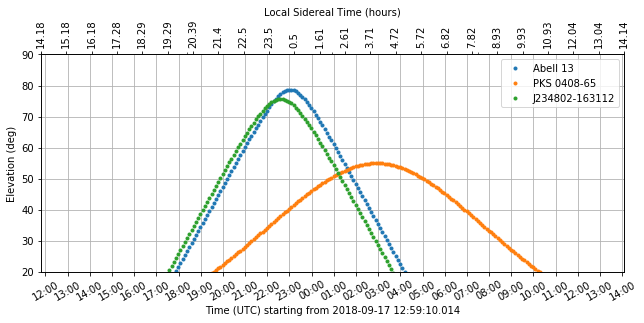

In [10]:
start_timestamp = katpoint.Timestamp()
t = start_timestamp.secs + np.arange(0, 24. * 60. * 60., 360.)
lst = katpoint.rad2deg(primary_target.antenna.local_sidereal_time(t)) / 15

fig, ax1 = plt.subplots()
fig.set_size_inches(12, 4)
plt.subplots_adjust(right=0.8)
lines = list()
labels = list()
fontP = FontProperties()
fontP.set_size('small')

for target in cat.targets:
    elev = katpoint.rad2deg(target.azel(t)[1])
    timestamps = Time(t, format='unix')
    myplot,= plt.plot_date(timestamps.datetime, elev, fmt = '.', linewidth = 0, label=target.name)
    lines.append(myplot)
    labels.append(target.name)
    lst_rise = lst[np.where(elev>20)[0][0]]
    lst_set = lst[np.where(elev>20)[0][-1]]
    print('%s is above 20 degrees between LST %.2f and %.2f '%(target.name, lst_rise, lst_set))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax1.xaxis.set_major_locator(mdates.HourLocator(byhour=range(24),interval=1))
labels = ax1.get_xticklabels()
plt.setp(labels, rotation=30, fontsize=10)
plt.ylim(20,90)
plt.grid()
plt.legend()
plt.ylabel('Elevation (deg)')
plt.xlabel ('Time (UTC) starting from %s'%start_timestamp.to_string())
ax2 = ax1.twiny()
ax2.xaxis.set_major_locator(MaxNLocator(24))
minorLocator = MultipleLocator(0.25)
ax2.xaxis.set_minor_locator(minorLocator)
new_ticks = plt.xticks(
    np.linspace(0,1,24),
    np.round(lst[np.linspace(1, len(lst), num=24, dtype = int)-1], 2),
    rotation = 'vertical')
plt.xlabel('Local Sidereal Time (hours)')


# Solar separation

Make sure all objects are at least 20 degrees from the Sun at the planned observation time.

In [11]:
sun = katpoint.Target('Sun, special')
for target in cat.targets: 
    sep = np.degrees(sun.separation(target, timestamp=katpoint.Timestamp('2018-06-17 05:00'), antenna=ant))
    print('%s is %.0f degrees from the sun'%(target.name, sep))


Abell 13 is 91 degrees from the sun
PKS 0408-65 is 91 degrees from the sun
J234802-163112 is 95 degrees from the sun


# Write catalogue

In [13]:
cat.save(cat_fname)  #note this will overwrite an existing file